In [1]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
import optuna.integration.lightgbm as lgbopt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train.csv')
test = pd.read_csv('/Users/siero5335/channel/test.csv')


sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

In [2]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

In [3]:
# https://www.kaggle.com/friedchips/clean-removal-of-data-drift
train_segm_separators = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])
train_segm_signal_groups = [0,0,0,1,2,4,3,1,2,3,4] # from visual identification
train_segm_is_shifted = [False, True, False, False, False, False, False, True, True, True, True] # from visual identification
train_signal = np.split(train['signal'].values, train_segm_separators[1:-1])
train_opench = np.split(train['open_channels'].values, train_segm_separators[1:-1])

In [4]:
test_segm_separators = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
test_segm_signal_groups = [0,2,3,0,1,4,3,4,0,2,0,0] # from visual id
test_segm_is_shifted = [True, True, False, False, True, False, True, True, True, False, True, False] # from visual id
test_signal = np.split(test['signal'].values, test_segm_separators[1:-1])

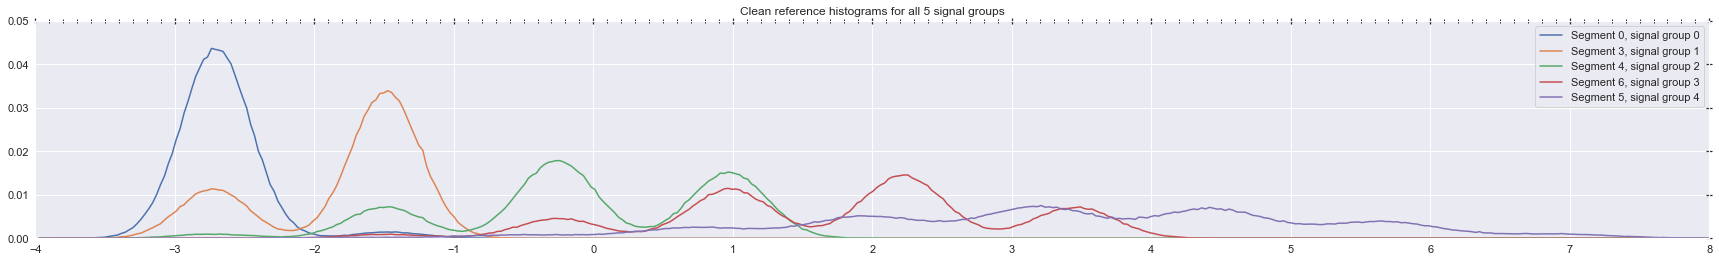

In [5]:
#create clean signal histograms
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[-4,8,1,.1], y_val=[0,0.05,0.01,0.01])

clean_hist = []
hist_bins = np.linspace(-4,10,500)

for j,i in enumerate([0,3,4,6,5]):
    clean_hist.append(np.histogram(train_signal[i], bins=hist_bins)[0])
    clean_hist[-1] = clean_hist[-1] / 500000 # normalize histogram
    axes.plot(hist_bins[1:], clean_hist[-1], label='Segment '+str(i)+', signal group '+str(j));
axes.legend();
axes.set_title("Clean reference histograms for all 5 signal groups");

In [6]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10 # maximum absolute change in shift from window to window+1
train_signal_shift = []

for clean_id in range(len(train_segm_signal_groups)):
    
    group_id = train_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0 # all signal groups start with shift=0
    window_data = train_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    train_signal_shift.append(window_shift)    

In [7]:
bin_width = np.diff(hist_bins)[0]
s_window = 10
test_signal_detrend = []
test_signal_shift = []

for clean_id in range(len(test_segm_signal_groups)):
    
    group_id = test_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0
    window_data = test_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    test_signal_shift.append(window_shift)    


In [8]:
train_signal_shift_clean = []
train_signal_detrend = []

for data, use_fit, signal in zip(train_signal_shift, train_segm_is_shifted, train_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    train_signal_shift_clean.append(data_2)
    train_signal_detrend.append(signal + data_2)

In [9]:
test_signal_shift_clean = []
test_signal_detrend = []
test_remove_shift = [True, True, False, False, True, False, True, True, True, False, True, False]

for data, use_fit, signal in zip(test_signal_shift, test_segm_is_shifted, test_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    test_signal_shift_clean.append(data_2)
    test_signal_detrend.append(signal + data_2)

In [10]:
train['signal'] = np.concatenate(train_signal_detrend)
test['signal'] = np.concatenate(test_signal_detrend)

In [11]:
zscore = lambda x: (x - x.mean()) / x.std()

window_sizes = [10, 50, 100, 500, 1000]

for window in window_sizes:
    train["rolling_mean_" + str(window)] = train['signal'].rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
    train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
    train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()
    
for window in window_sizes:
    test["rolling_mean_" + str(window)] = test['signal'].rolling(window=window).mean()
    test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
    test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
    test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()
    
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
                                            
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['skew'+c] = df.groupby([c])['signal'].skew()
                
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan
        
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

train_y = train['open_channels']

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
train.head()

,time,signal,open_channels,rolling_mean_10,rolling_std_10,rolling_min_10,rolling_max_10,rolling_mean_50,rolling_std_50,rolling_min_50,...,stdbatch_slices2_msignal,skewbatch_slices2_msignal,mean_abs_chgbatch_slices2_msignal,abs_maxbatch_slices2_msignal,abs_minbatch_slices2_msignal,rangebatch_slices2_msignal,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift_+1_msignal,signal_shift_-1_msignal
0.0,0.0001,-2.7600,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.00295158,2.79843479,3.02972949,6.3496,4.6226,4.4870,3.2788879,5.4861,0.0000,-0.0957
1.0,0.0002,-2.8557,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.09865158,2.89413479,3.12542949,6.4453,4.7183,4.5827,3.3745879,5.5818,0.0957,0.4483
2.0,0.0003,-2.4074,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.65035158,2.44583479,2.67712949,5.9970,4.2700,4.1344,2.9262879,5.1335,-0.4483,-0.7330
3.0,0.0004,-3.1404,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.38335158,3.17883479,3.41012949,6.7300,5.0030,4.8674,3.6592879,5.8665,0.7330,-0.0121
4.0,0.0005,-3.1525,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.39545158,3.19093479,3.42222949,6.7421,5.0151,4.8795,3.6713879,5.8786,0.0121,0.5107


In [13]:
test.head()

,time,signal,rolling_mean_10,rolling_std_10,rolling_min_10,rolling_max_10,rolling_mean_50,rolling_std_50,rolling_min_50,rolling_max_50,...,stdbatch_slices2_msignal,skewbatch_slices2_msignal,mean_abs_chgbatch_slices2_msignal,abs_maxbatch_slices2_msignal,abs_minbatch_slices2_msignal,rangebatch_slices2_msignal,maxtominbatch_slices2_msignal,abs_avgbatch_slices2_msignal,signal_shift_+1_msignal,signal_shift_-1_msignal
5000000.0,500.0001,-2.67534728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.92016297,2.70612719,2.94607662,6.23976232,4.54398610,4.37112351,3.19959567,5.39187421,0.00000000,-0.19963165
5000001.0,500.0002,-2.87497894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.11979462,2.90575885,3.14570827,6.43939397,4.74361775,4.57075516,3.39922732,5.59150586,0.19963165,-0.01063165
5000002.0,500.0003,-2.88561059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.13042627,2.91639050,3.15633992,6.45002562,4.75424940,4.58138681,3.40985897,5.60213751,0.01063165,0.42496835
5000003.0,500.0004,-2.46064224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.70545792,2.49142215,2.73137157,6.02505727,4.32928105,4.15641846,2.98489062,5.17716916,-0.42496835,-0.18053165
5000004.0,500.0005,-2.64117389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.88598957,2.67195380,2.91190322,6.20558892,4.50981270,4.33695011,3.16542227,5.35770081,0.18053165,0.04956835


In [14]:
#train.to_csv('/Users/siero5335/channel/train_mod.csv')
#test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [15]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

train = train[col]
test = test[col]

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [16]:
from sklearn import model_selection
train_features, valid_features, train_labels, valid_labels = model_selection.train_test_split(train, train_y, test_size=0.2)

In [17]:
trains = lgb.Dataset(train_features, train_labels)
valids = lgb.Dataset(valid_features, valid_labels)

In [18]:
params = {
    'learning_rate': 0.3, 
    'metric': 'l1',
    'bagging_fraction': 1.0,
    'bagging_freq': 0
}
best_params, history = {}, []
model = lgbopt.train(params, trains, valid_sets=valids,
                    verbose_eval=False,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    best_params=best_params,
                    tuning_history=history)

tune_num_leaves, val_score: 0.047902: 100%|##########| 20/20 [15:59<00:00, 47.98s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.047902:  10%|#         | 1/10 [00:27<04:09, 27.73s/it][I 2020-03-14 11:53:20,723] Finished trial#0 resulted in value: 0.048039458610627556. Current best value is 0.048039458610627556 with parameters: {'bagging_fraction': 0.8684344486273968, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.047902:  20%|##        | 2/10 [00:47<03:22, 25.29s/it][I 2020-03-14 11:53:40,330] Finished trial#1 resulted in value: 0.048182225731253685. Current best value is 0.048039458610627556 with parameters: {'bagging_fraction': 0.8684344486273968, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.047902:  30%|###       | 3/10 [01:07<02:46, 23.83s/it][I 2020-03-14 11:54:00,737] Finished trial#2 resulted in value: 0.04823490926765044. Current best value is 0.048039458610627556 with parameters: {'bagging_fraction': 0.86843444862

In [21]:
best_params

{'lambda_l1': 0.06011346668017576,
 'lambda_l2': 2.1221201883793873e-06,
 'num_leaves': 252,
 'feature_fraction': 0.748,
 'bagging_fraction': 0.9100169988119422,
 'bagging_freq': 5,
 'min_child_samples': 20}

In [26]:
best_params.update(learning_rate = 0.01, bagging_fraction = 1.0, bagging_freq = 0,  metric = 'mae', random_state= 71, n_jobs=-1)

In [27]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = best_params

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=100)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Sat Mar 14 12:35:12 2020
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.808644	valid_1's l1: 0.808693
[200]	training's l1: 0.307922	valid_1's l1: 0.308129
[300]	training's l1: 0.13451	valid_1's l1: 0.134934
[400]	training's l1: 0.075364	valid_1's l1: 0.0759492
[500]	training's l1: 0.0556131	valid_1's l1: 0.0563564
[600]	training's l1: 0.0492458	valid_1's l1: 0.0501284
[700]	training's l1: 0.0472302	valid_1's l1: 0.0482527
[800]	training's l1: 0.0465288	valid_1's l1: 0.0476826
[900]	training's l1: 0.0462131	valid_1's l1: 0.0474975
[1000]	training's l1: 0.0460371	valid_1's l1: 0.0474352
[1100]	training's l1: 0.0459031	valid_1's l1: 0.0474125
[1200]	training's l1: 0.0457667	valid_1's l1: 0.0473905
[1300]	training's l1: 0.0456358	valid_1's l1: 0.0473732
[1400]	training's l1: 0.0455124	valid_1's l1: 0.0473613
[1500]	training's l1: 0.0453938	valid_1's l1: 0.0473533
[1600]	training's l1: 0.0452795	valid_1's l1: 0.0473477
[1700]	training'

In [28]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [29]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.51163853 1.5234673  2.49553747 3.50335728 4.52092071 5.46864433
 6.51777505 7.50553777 8.47500203 9.46550646]


In [30]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9385148487739806

In [31]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [32]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('maeopt.csv', index=False, float_format='%.4f')

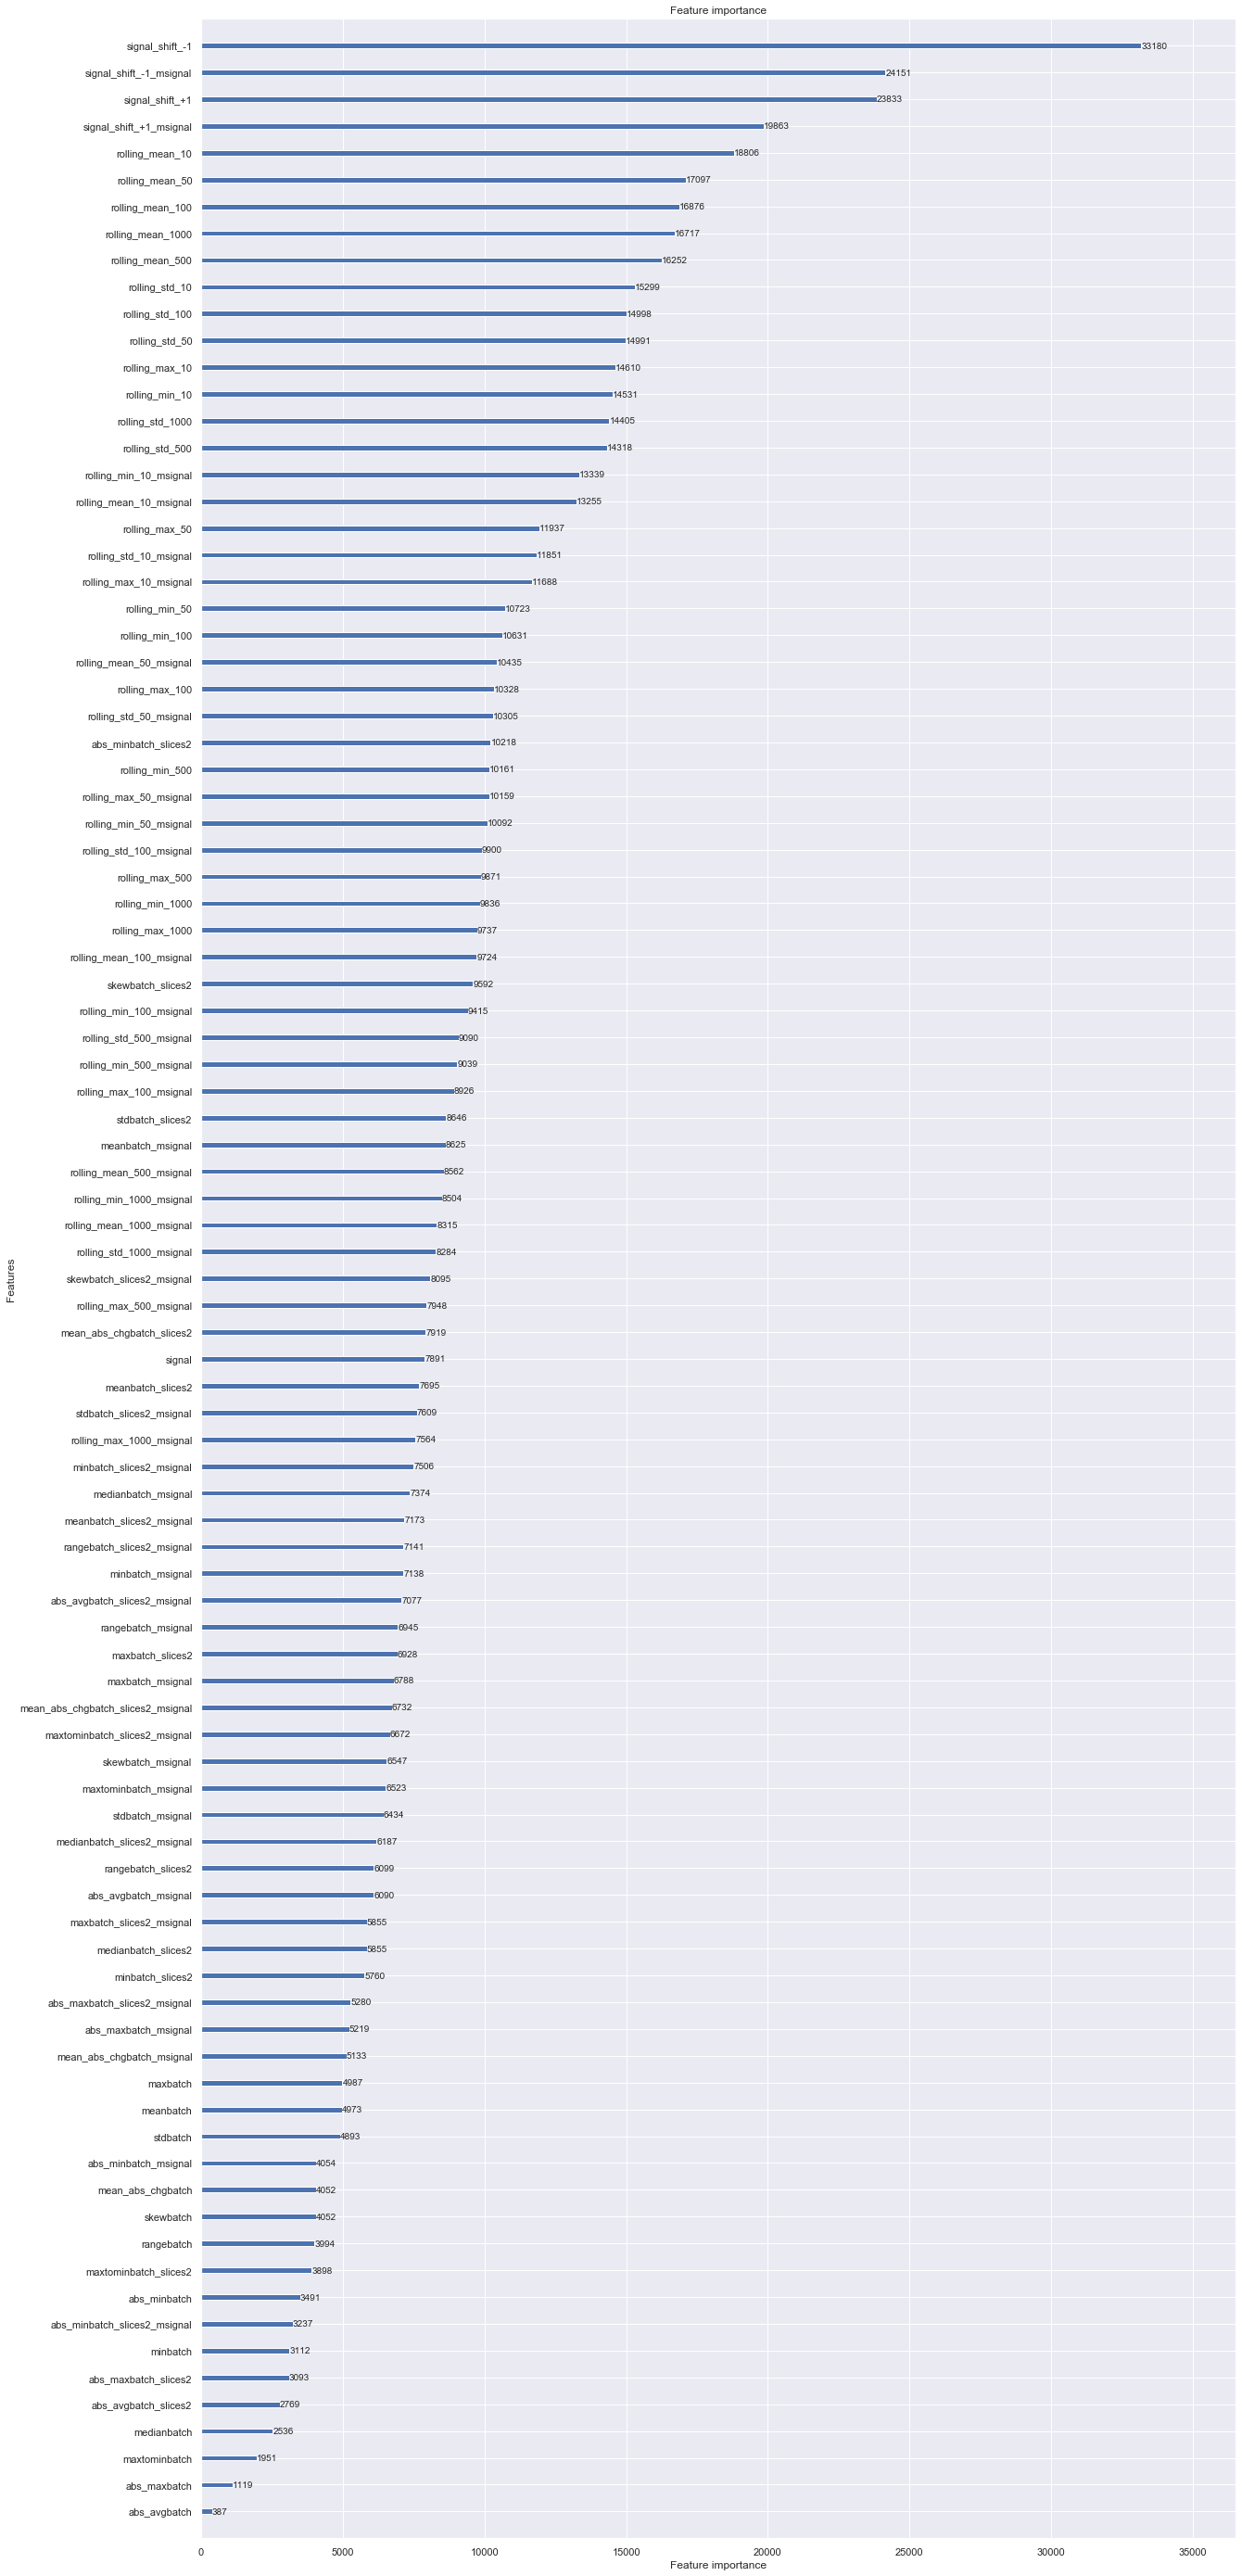

In [33]:
lgb.plot_importance(model,importance_type='split', max_num_features=200, figsize=(20, 50))